In [ ]:
SQL_FILE_PATH = "historic_data.sqlite"

# Relevant Libraries

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, Latex

In [ ]:
sqlite_connection = sqlite3.connect(SQL_FILE_PATH)

# Utility Functions and constants

In [ ]:
percentiles = [0,0.005,0.25,0.5,0.75,0.995,1]
cols_to_keep = ["mean", "0%", "0.5%", "25%", "50%", "75%", "99.5%", "100%"]

def get_conditional_correlation_df(dataset, var1, var2, cond_var, index_name, significance=0.95):
    cond_corr_df = pd.DataFrame()
    cond_corr_df[
        f"Estimate"
    ] = race_data.groupby(cond_var).apply(
        lambda x : scipy.stats.pearsonr(x[var1], x[var2])[0]
    )
    cond_corr_df[
        f"p-value"
    ] = race_data.groupby(cond_var).apply(
        lambda x : scipy.stats.pearsonr(x[var1], x[var2])[1].round(5)
    )
    cond_corr_df[
        f"Lower {np.round(100*(1-significance)/2,2)}% CI Bound"
    ] = race_data.groupby(cond_var).apply(
        lambda x : scipy.stats.pearsonr(x[var1], x[var2]).confidence_interval(significance)[0]
    )
    cond_corr_df[
        f"Upper {np.round(100*(significance+1)/2,2)}% CI Bound"
    ] = race_data.groupby(cond_var).apply(
        lambda x : scipy.stats.pearsonr(x[var1], x[var2]).confidence_interval(significance)[1]
    )
    cond_corr_df.index.name = index_name
    return cond_corr_df

# Analysis of Race Related Data

In [ ]:
race_sql_query = """
SELECT
DISTINCT(race_id) as race_id,
course as race_course,
race_type,
going as race_going_condition,
direction as race_direction,
meeting_date as date,
distance_yards,
winning_time_secs,
added_money
FROM
historic_races
"""

race_data = pd.read_sql(race_sql_query, sqlite_connection)

In [ ]:
print(f"Number of races : {race_data['race_id'].nunique()}")
print(
    f"Number of races with prize less than E10 or prize nan : {(race_data['added_money']<10).astype(int).sum() + (race_data['added_money'].isna()).astype(int).sum()}"
)
print(
    f"Number of races with winner time less than 30 seconds : {(race_data['winning_time_secs']<30).astype(int).sum()}"
)
print(
    f"Number of races where going condition is not recorded : {race_data['race_going_condition'].apply(lambda x : x is None).sum()}"
)


Number of races : 265110
Number of races with prize less than E10 or prize nan : 460
Number of races with winner time less than 30 seconds : 1732
Number of races where going condition is not recorded : 696


In [ ]:
race_data['race_type'].value_counts().to_frame()

,count
race_type,
Flat,102287
Hurdle,58430
All Weather Flat,54645
Chase,39481
National Hunt Flat,10255
Trotting,10
Point to Point,2


In [ ]:
race_data = race_data[race_data['race_type'].apply(lambda x : x not in {"Trotting", "Point to Point"})]

In [ ]:
race_data['log_distance_yards'] = np.log(race_data['distance_yards'])
race_data[['distance_yards', 'log_distance_yards']].describe(percentiles=percentiles).T[cols_to_keep]

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,mean,0%,0.5%,25%,50%,75%,99.5%,100%
distance_yards,2836.383912,1038.000000,1100.000000,1540.000000,2640.000000,3850.000000,5940.000000,7920.000000
log_distance_yards,7.823557,6.945051,7.003065,7.339538,7.878534,8.255828,8.689464,8.977146


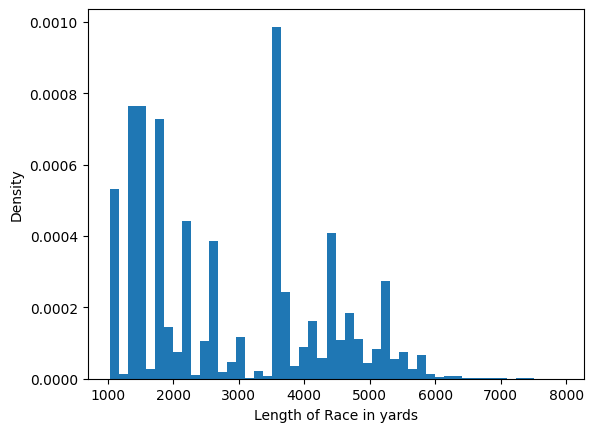

In [ ]:
race_data['distance_yards'].plot.hist(
    bins = 50,
    xlabel="Length of Race in yards",
    ylabel="Density",
    #title="Distribution of Length of Race",
    density=True
)
plt.show()

In [ ]:
race_data['log_winning_time_secs'] = np.log(race_data['winning_time_secs']+1e-5)
race_data[['winning_time_secs', 'log_winning_time_secs']].describe(percentiles=percentiles).T[cols_to_keep]

,mean,0%,0.5%,25%,50%,75%,99.5%,100%
winning_time_secs,184.809630,0.000000,0.000000,88.390000,149.900000,268.307500,445.756350,3599.400000
log_winning_time_secs,4.942106,-11.512925,-11.512925,4.481759,5.009968,5.592134,6.099773,8.188522


In [ ]:
race_data = race_data[(race_data['winning_time_secs']>30)]

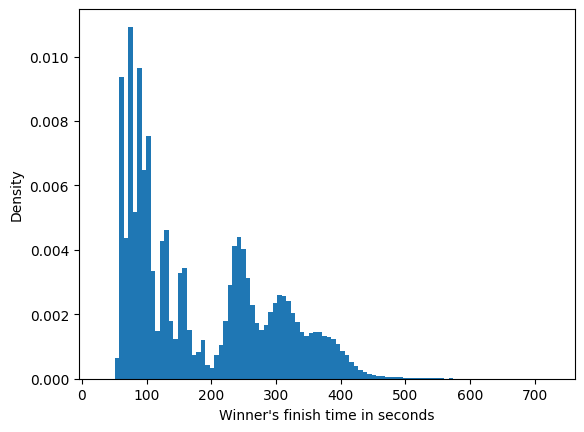

In [ ]:
race_data['winning_time_secs'][race_data['winning_time_secs']<1000].plot.hist(
    bins = 100,
    xlabel="Winner's finish time in seconds",
    ylabel="Density",
    #title="Distribution of Winner's finish time\n (Truncated on right for values greater than 1000)",
    density=True
)
plt.show()

In [ ]:
race_data['log_added_money'] = np.log(race_data['added_money']+1e-5)
race_data[['added_money', 'log_added_money']].describe(percentiles=percentiles).T[cols_to_keep]#.to_latex(float_format="{:.2f}".format))

,mean,0%,0.5%,25%,50%,75%,99.5%,100%
added_money,14111.491716,0.000000,2000.000000,5000.000000,7327.590000,11000.000000,200000.000000,1.625000e+06
log_added_money,9.010488,-11.512925,7.600902,8.517193,8.899402,9.305651,12.206073,1.430102e+01


In [ ]:
race_data = race_data[race_data['added_money']>10]

<Axes: xlabel='$ln($Total Prize Pool in GBP$)$', ylabel='Density'>

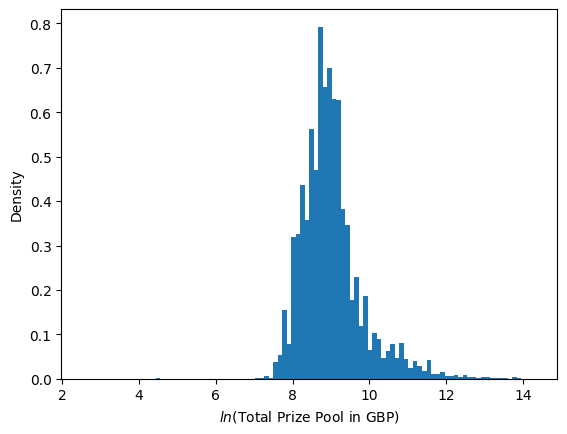

In [ ]:
race_data['log_added_money'][race_data['added_money']>10].plot.hist(
    bins=100,
    xlabel="$ln($Total Prize Pool in GBP$)$",
    ylabel="Density",
    #title="Distribution of Length of Race",
    density=True

)

In [ ]:
race_data['winners_speed'] = race_data['distance_yards']/(race_data['winning_time_secs'])
race_data['log_winners_speed'] = np.log(race_data['winners_speed'])
race_data[['winners_speed', 'log_winners_speed']].describe(percentiles=percentiles).T[cols_to_keep]

,mean,0%,0.5%,25%,50%,75%,99.5%,100%
winners_speed,16.180121,0.305606,12.390395,14.632238,16.595424,17.630223,19.120459,150.273224
log_winners_speed,2.777350,-1.185457,2.516922,2.683227,2.809127,2.869615,2.950759,5.012455


In [ ]:
race_data = race_data[(race_data['winners_speed']>10) & (race_data['winners_speed']<20)]

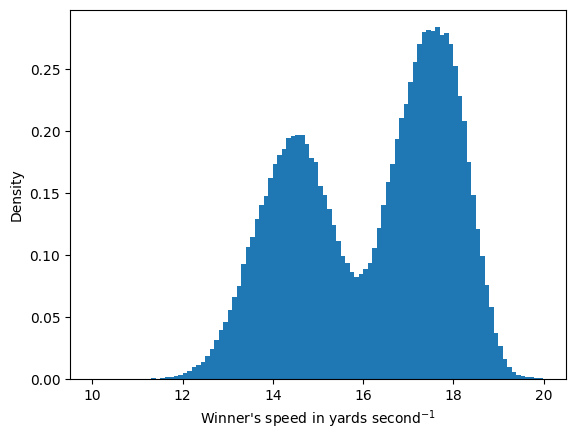

In [ ]:
race_data['winners_speed'].plot.hist(
    bins = 100,
    xlabel="Winner's speed in yards second$^{-1}$",
    ylabel="Density",
    #title="Distribution of Winner's finish time",
    density=True
)
plt.show()

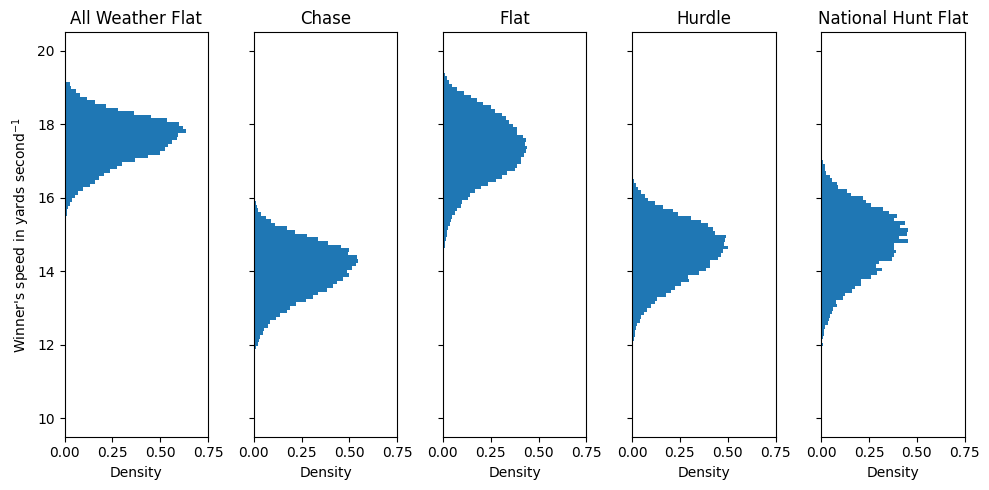

In [ ]:
ax = race_data.plot.hist(
    column='winners_speed',
    bins = 100,
    by="race_type",
    ylabel="Winner's speed in yards second$^{-1}$",
    xlabel="Density",
    #title="Distribution of Winner's finish time conditioned on Race Type",
    density=True,
    figsize=(10,5),
    legend=False,
    layout=(1, 5),
    orientation='horizontal',
    sharey=True,
    xlim=(0,0.75)
)
plt.tight_layout()
plt.show()

In [ ]:
get_conditional_correlation_df(race_data, "log_distance_yards", "log_winners_speed", "race_type", "Race Type")#.to_latex(float_format="{:.2f}".format).replace("%","\%"))

/tmp/ipykernel_163/954717267.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ] = race_data.groupby(cond_var).apply(
/tmp/ipykernel_163/954717267.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ] = race_data.groupby(cond_var).apply(
/tmp/ipykernel_163/954717267.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of 

,Estimate,p-value,Lower 2.5% CI Bound,Upper 97.5% CI Bound
Race Type,,,,
All Weather Flat,-0.658518,0.00000,-0.663264,-0.653720
Chase,-0.221997,0.00000,-0.231399,-0.212553
Flat,-0.586648,0.00000,-0.590670,-0.582598
Hurdle,-0.173669,0.00000,-0.181551,-0.165764
National Hunt Flat,0.010010,0.31361,-0.009460,0.029472


In [ ]:
scipy.stats.pearsonr(race_data['log_distance_yards'].values, race_data['log_winners_speed'].values)

PearsonRResult(statistic=-0.8662053351093485, pvalue=0.0)

In [ ]:
get_conditional_correlation_df(race_data, "log_added_money", "log_winners_speed", "race_type", "Race Type")#.to_latex(float_format="{:.2f}".format).replace("%","\%"))

/tmp/ipykernel_163/954717267.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ] = race_data.groupby(cond_var).apply(
/tmp/ipykernel_163/954717267.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ] = race_data.groupby(cond_var).apply(
/tmp/ipykernel_163/954717267.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of 

,Estimate,p-value,Lower 2.5% CI Bound,Upper 97.5% CI Bound
Race Type,,,,
All Weather Flat,0.219501,0.00000,0.211467,0.227505
Chase,0.033671,0.00000,0.023768,0.043568
Flat,0.049052,0.00000,0.042911,0.055188
Hurdle,-0.003760,0.36529,-0.011899,0.004380
National Hunt Flat,-0.099569,0.00000,-0.118807,-0.080257


In [ ]:
scipy.stats.pearsonr(race_data['log_added_money'].values, race_data['log_winners_speed'].values)

PearsonRResult(statistic=-0.02944228996466881, pvalue=1.7045558239299492e-51)

In [ ]:
get_conditional_correlation_df(race_data, "log_distance_yards", "log_winners_speed", "race_going_condition", "Race Type")

/tmp/ipykernel_163/954717267.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ] = race_data.groupby(cond_var).apply(
/tmp/ipykernel_163/954717267.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ] = race_data.groupby(cond_var).apply(
/tmp/ipykernel_163/954717267.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of 

,Estimate,p-value,Lower 2.5% CI Bound,Upper 97.5% CI Bound
Race Type,,,,
Fast,-0.967524,0.00156,-0.996572,-0.726104
Firm,-0.844212,0.00000,-0.852639,-0.835345
Good,-0.898461,0.00000,-0.899913,-0.896989
Good - Firm,-0.953659,0.00000,-0.982906,-0.877470
Good - Yielding,-0.884573,0.00000,-0.893889,-0.874492
Good to Firm,-0.868919,0.00000,-0.871206,-0.866595
Good to Soft,-0.894669,0.00000,-0.896859,-0.892435
Hard,-0.010205,0.98268,-0.757442,0.748606
Heavy,-0.842827,0.00000,-0.847202,-0.838337


In [ ]:
get_conditional_correlation_df(race_data, "log_added_money", "log_winners_speed", "race_going_condition", "Race Type")

/tmp/ipykernel_163/954717267.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ] = race_data.groupby(cond_var).apply(
/tmp/ipykernel_163/954717267.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ] = race_data.groupby(cond_var).apply(
/tmp/ipykernel_163/954717267.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of 

,Estimate,p-value,Lower 2.5% CI Bound,Upper 97.5% CI Bound
Race Type,,,,
Fast,0.314169,0.54425,-0.667612,0.897019
Firm,-0.073381,0.00000,-0.103230,-0.043400
Good,0.151529,0.00000,0.144111,0.158931
Good - Firm,-0.393729,0.10596,-0.726968,0.089614
Good - Yielding,0.192299,0.00000,0.149060,0.234804
Good to Firm,0.194696,0.00000,0.185627,0.203732
Good to Soft,0.083849,0.00000,0.072835,0.094843
Hard,0.351777,0.43906,-0.545893,0.873451
Heavy,0.078349,0.00000,0.063125,0.093537


# Analysis of Horse/Runner Related Data

In [ ]:
horse_sql_query = """SELECT
runner_id,
race_id,
gender as runner_gender,
age as runner_age,
bred as runner_breeding_country,
distance_travelled,
distance_behind_winner,
finish_position
FROM
historic_runners
"""
horse_data = pd.read_sql(horse_sql_query, sqlite_connection)

In [ ]:
print(
    f"Number of races with 1 or 2 participants : {(horse_data.groupby('race_id')['runner_id'].nunique()<=2).sum()}"
)

Number of races with 1 or 2 participants : 182


In [ ]:
horse_data['runner_gender'].value_counts().to_frame()

,count
runner_gender,
G,1528367
F,476070
M,281196
C,204765
H,16174
R,186


In [ ]:
horse_data[['runner_id', 'runner_gender']].dropna().groupby('runner_id')['runner_gender'].nunique().value_counts().to_frame()

,count
runner_gender,
1,169742
2,37185
3,419
4,1


In [ ]:
horse_data[['runner_id', 'runner_gender']].dropna().groupby('runner_id')['runner_gender'].nunique()[horse_data[['runner_id', 'runner_gender']].dropna().groupby('runner_id')['runner_gender'].nunique()==4]

runner_id
600134    4
Name: runner_gender, dtype: int64

In [ ]:
horse_data[horse_data['runner_id']==600134]['runner_gender'].value_counts()

runner_gender
G    70
M     4
H     4
C     1
Name: count, dtype: int64

In [ ]:
horse_data['runner_age'].describe(percentiles=percentiles).to_frame().T[cols_to_keep]#.to_latex(float_format="{:.2f}".format))

,mean,0%,0.5%,25%,50%,75%,99.5%,100%
runner_age,5.062465,-128.0,2.0,3.0,5.0,6.0,12.0,127.0


In [ ]:
horse_data['runner_age'][
    (
        (horse_data['runner_age']<=50) & (horse_data['runner_age']>=0)
    )
].describe(percentiles=percentiles).to_frame().T[cols_to_keep]#.to_latex(float_format="{:.2f}".format))

,mean,0%,0.5%,25%,50%,75%,99.5%,100%
runner_age,5.054944,1.0,2.0,3.0,5.0,6.0,12.0,22.0


In [ ]:
horse_data['runner_age'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
runner_age,2507363.0,5.062465,2.565126,-128.0,3.0,5.0,6.0,127.0


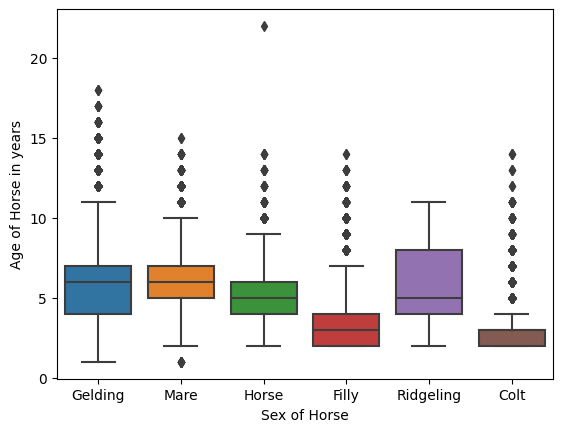

In [ ]:
row_subset = (horse_data['runner_age']>0) & (horse_data['runner_age']<50)
column_subset = ['runner_gender', 'runner_age']
ax = sns.boxplot(
    horse_data.loc[row_subset, column_subset],
    x = "runner_gender",
    y = "runner_age",
)
ax.set(
    xlabel='Sex of Horse',
    ylabel='Age of Horse in years',
    #title = "Distribution of age of runner\n conditioned on sex of runner",
)
ax.set_xticklabels(["Gelding","Mare","Horse",'Filly',"Ridgeling","Colt"])
plt.show()

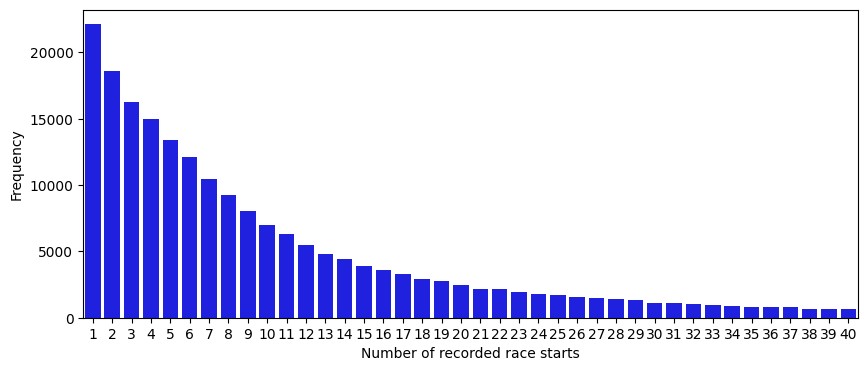

In [ ]:
n_runs = horse_data.groupby('runner_id')['race_id'].nunique().value_counts().to_frame()
n_runs.index.name = 'Number of recorded race starts'
n_runs.columns = ['Density']
n_runs = n_runs.sort_index()
n_runs = n_runs.loc[:40]
plt.figure(figsize=(10,4))
ax = sns.barplot(
    y = n_runs["Density"].values,
    x = n_runs.index,
    color = "blue",
)

#plt.setp(ax.get_xticklabels(), rotation=90)
ax.set(
    #title="Distribution of number of races a given horse runs\n (Truncated on rights for values greater than 40)",
    ylabel="Frequency"
)

plt.show()